# FREE-ENERGY PRINCIPLE (FEP) TUTORIAL 4
## Visual-proprioceptive conflict under Active Inference
### Modelling the Rubber-hand illusion perceptual drift

**Author: [Pablo Lanillos](https://www.ru.nl/personen/lanillos-p/).** Donders Institute for Brain, Cognition and Behaviour. Radboud University. The Netherlands.

<font color='green'>**Difficulty: high**</font>

This tutorial is based on the paper:
- Ref: Lanillos, Pablo, Sae Franklin, and David W. Franklin. "The predictive brain in action: Involuntary actions reduce body prediction errors." bioRxiv (2020). https://www.biorxiv.org/content/10.1101/2020.07.08.191304v1

Version note: Visual and proprioceptive inputs + no affecting attractor

Further reading:
- Oliver, G., Lanillos, P., & Cheng, G. (2019). Active inference body perception and action for humanoid robots. arXiv preprint arXiv:1906.03022.
- Hinz, N. A., Lanillos, P., Mueller, H., & Cheng, G. (2018). Drifting perceptual patterns suggest prediction errors fusion rather than hypothesis selection: replicating the rubber-hand illusion on a robot. IEEE international conference on development and learning and on epigenetic robotics (ICDL-Epirob 2018)
- Friston, K. J., Daunizeau, J., Kilner, J., & Kiebel, S. J. (2010). Action and behavior: a free-energy formulation. Biological cybernetics, 102(3), 227-260.

## Description

1. When you ask human participants to locate their arm/hand (that is hidden) after experiencing the [rubber-hand illusion experiment](https://en.wikipedia.org/wiki/Body_transfer_illusion#Rubber_hand_illusion) they misslocalize it. In particular participants estimate the location of the arm closer to the rubber arm. With this tutorial you will learn to model this called *proprioceptive drift* under the Free Energy Principle (FEP).

2. We showed that also small forces appear towards the rubber-hand, in this case the virtual hand, as the participant is trying to fit its body to match the visual input. With this tutorial you will learn how to model these involuntary movements under the Active Inference paradigm, the FEP that includes the action.

## Problem modelling
We model the arm with one degree of freedom, thus we only use the elbow rotation. The virtual hand, modelled as a 2-dimensional point in the space is our visual input. The system also counts with a sensor that provides the joint angle. See figure below
![hand model](https://drive.google.com/uc?id=1zJwxVrBGvjiZf2nUvlpdF9cij7sOavua)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv


### Participants model


In [ ]:
# helper functions

class Participant:
    def __init__(self):
        mu_arm = 44.7208  # From Fuchs data
        std_arm = 2.4807  # From Fuchs data

        # Participants differences have been disabled for code debuging.
        mu_bias_real = 0.
        std_bias_real = 0.
        mu_bias_artificial = -3.9440
        std_bias_artificial = 3.9949

        self.L = (std_arm * np.random.randn() + mu_arm) * 0.01  # arm length (cm)
        self.bias_real = 0.  
        self.bias_artificial = 0. 

        # Inverse variances or cues precision
        self.Sigma_x_1 = np.diag(np.exp([1., 1., 1.]))
        self.Sigma_v_1 = np.exp(0.1) # not used
        self.Sigma_s_1 = np.diag(np.exp([1., 1., 1., 1.])) # x

        self.sync_mean = 0.
        self.sync_sigma = 20.

        print('s', self.Sigma_s_1)
        print('x', self.Sigma_x_1)

### Experimental setup for each trial

In [ ]:
class Trial:
    def __init__(self, location=0, sync=0):
        # position of the virtual hand
        self.location_conditions = np.array([-15, 0, 15])  # L, C, R
        self.distance_fhand = self.location_conditions[location] * 0.01  # in cm
        self.sync = sync
        # Time step
        self.dt = 0.001
        # Trial time
        self.time = 60  # seconds
        # Number of steps
        self.Nt = np.floor(self.time / self.dt)
        # Visuotactile stimulation init
        self.tinit = 1
        # Visuotactile stimulation ends
        self.tend = 50
        # Total time steps for the AI computation
        self.total_steps = np.arange(self.dt, self.Nt * self.dt, self.dt)
        # Real time steps
        self.t1 = np.arange(round(self.tinit / self.dt), round(self.tend / self.dt))
        self.data = []  # Store data


    def visualize_experiment(self, human, s_r0, s_v0, s_v_hat, rho, x):
        print('Hands location estimation at the end of the trial')
        # visualize experiment
        for l in self.location_conditions:
            plt.plot([l * 0.01, l * 0.01], [0, human.L], 'k--', alpha=0.5)

        plt.plot([0, s_v0], [0, human.L * np.cos(x)], 'mo--')  # real hand
        plt.text(0 + 0.005, human.L - 0.1, 'real hand', color='m')
        plt.plot([s_r0, s_r0], [0, human.L], 'b.-')  # VR hand
        plt.text(s_r0 + 0.005, human.L - 0.13, 'VR hand', color='b')
        plt.plot([s_v_hat], [human.L], 'r.-', markersize=20, alpha=0.5)  # Predicted hand horizontal location
        plt.text(s_v_hat + 0.01, human.L - 0.01, 'predReal', color='r')
        plt.plot([rho], [human.L], 'b.-', markersize=20, alpha=0.5)  # Predicted VR hand horizontal location
        plt.text(rho - 0.04, human.L - 0.04, 'predVR', color='b')

        plt.grid()
        plt.show()

    def reset_data(self):
        self.data = []

    def visualize_data(self):
        w = 8
        h = 4
        data = np.array(self.data).T
        steps = self.total_steps[0:data.shape[1] + 1]

        # arms location
        plt.figure(figsize=(w, h))
        plt.plot(steps, np.ones(len(steps)) * self.distance_fhand, '-.k',
                 label='VR arm location')  # artificial hand location
        plt.plot(steps, data[2, :], '--', color=[0.2, 0.2, 0.5],
                 label=r'$\rho$ - causal variable VR')  # artificial hand location
        plt.plot(steps, data[3, :], linewidth=2, color=[0.8, 0.3, 0.3],
                 label=r'$g(\mu)$ - estimated hand location')  # real hand prediction
        plt.plot(steps, data[17, :], '--', color='k', label='real arm location')  # real hand location (static)
        plt.legend()
        plt.xlabel('time (s)')
        plt.ylabel('horizontal location (cm)')
        plt.ylim([-0.2, 0.2])
        plt.show()

        plt.figure(figsize=(w, h))
        plt.title('Real arm variables')
        plt.plot(steps, data[6, :] * 180. / np.pi, linewidth=2, color='r', label=r'$x$')
        plt.plot(steps, data[7, :] * 180. / np.pi, linewidth=2, color='b', label=r'$x^{\prime}$')
        plt.xlabel('time (s)')
        plt.ylabel('joint angles (deg, deg/s)')
        plt.grid()
        plt.legend()
        plt.show()

        plt.figure(figsize=(w, h))
        plt.title('Inferred Body state (Brain variables)')
        plt.plot(steps, data[0, :] * 180. / np.pi, linewidth=2, color='r', label=r'$\mu$')
        plt.plot(steps, data[1, :] * 180. / np.pi, linewidth=2, color='b', label=r'$\mu\prime$')
        plt.plot(steps, data[16, :] * 180. / np.pi, linewidth=2, color='g', label=r'$\mu^{\prime\prime}$')
        plt.xlabel('time (s)')
        plt.ylabel('inferred joint angles (deg, deg/s)')
        plt.grid()
        plt.legend()
        plt.show()

        plt.figure(figsize=(w, h))
        plt.title('Prediction errors')
        plt.plot(steps, data[8, :], linewidth=2, label=r'$e_{s_p}$')  # es
        plt.plot(steps, data[9, :], linewidth=2, label=r'$e_{s_v}$')  # es
        plt.plot(steps, data[13, :], linewidth=2, label=r'$e_{\rho}$')  # erho
        plt.plot(steps, data[11, :], linewidth=2, label=r'$e_{\mu_0}$')  # ex
        plt.plot(steps, data[12, :], linewidth=2, label=r'$e_{\mu_1}$')  # ex
        plt.xlabel('time (s)')
        plt.ylabel('Prediction errors')
        plt.legend()
        # plt.ylim([-0.1,0.1])

        plt.figure(figsize=(w, h))
        plt.title('dot a')
        plt.plot(steps, data[4, :], color=[0.8, 0.3, 0.3], linewidth=2, label=r'$\dot{a}$')
        plt.grid()
        plt.legend()
        # plt.ylim([-0.5,0.5])
        plt.show()

        plt.figure(figsize=(w, h))
        plt.title('Torque and force')
        plt.plot(steps, data[5, :], color=[0.8, 0.3, 0.3], linewidth=2, label='torque')
        plt.plot(steps, data[15, :], color=[0.3, 0.3, 0.8], linewidth=2, label='force')
        plt.grid()
        plt.legend()
        # plt.ylim([-0.08,0.08])
        plt.show()



### Active Inference model and arm model 


In [ ]:
## Arm equations and generative functions
class Model:
    def __init__(self, human):
        self.beta = 0.0 # prior likelihood of visuotactile synchrony.
        self.a_gain = 0.01
        self.a_saturation = 1.
        self.k = 1 / 4  # elasticity
        self.phi = 2  # viscosity
        self.m = 1  # mass
        self.L = human.L  # arm length
        self.bias_real = human.bias_real  # perceptual bias
        self.alphawrap = -np.pi / 2.0

    def f_real(self, x, rho, a):   
        # Mass-spring-damper
        return np.array([x[1][0], (a - self.k*x[0][0] -self.phi*x[1][0])/self.m, 0.]).reshape(3,1)

    def g_real(self, x):
        return self.L * np.cos(x[0][0] + self.alphawrap)

    def T(self, x):  # transformation to joint
        return -self.L * np.sin(x[0][0] + self.alphawrap)

    def A(self, x, rho):  # attractor
        return self.beta * (rho - self.gv(x))

    def gv(self, x):
        return self.L * np.cos(x[0][0] + self.alphawrap)  # + self.bias_real

    def g(self, x, rho):
        return np.array([x[0][0], x[1][0], self.gv(x), rho]).reshape(4, 1)


    # No attractor
    def f(self, x, rho):
        return np.array([x[1][0],
                             (- self.k * x[0][0]) / self.m,  # Only position component
                             0.]).reshape(3, 1)

    def dgv_x(self, x):
        return self.T(x)

    def dg_dx(self, x):
        return np.array([[1., 0., 0.], [0., 1., 0.], [self.dgv_x(x), 0., 0.], [0., 0., 0.]])

    def dg_drho(self, rho):
        return -1.


    # No attractor
    def df_dx(self, x, rho):
        return np.array([[0., 1., 0.],
                         [-self.k / self.m, 0., 0.],
                         [0., 0., 0.]])


    def df_drho(self, x, rho):
        return np.array([0., -self.T(x) * (self.beta / self.m), 0.]).reshape(3, 1)

    def ds_da(self, x, rho):
        return 1 / self.k

    def set_beta(self, beta):
        self.beta = beta
   


### Run experiment

Fake hand location - location_condition = (0 - Left, 1 - Center, 2 - Right)


In [ ]:
# Run experiment
print(' > Generating participant')
human = Participant()
# assign model equations
model = Model(human)

 > Generating participant
s [[2.71828183 0.         0.         0.        ]
 [0.         2.71828183 0.         0.        ]
 [0.         0.         2.71828183 0.        ]
 [0.         0.         0.         2.71828183]]
x [[2.71828183 0.         0.        ]
 [0.         2.71828183 0.        ]
 [0.         0.         2.71828183]]


 > Building trial: loc: right  sync: 1 experiment visualization below
Hands location estimation at the end of the trial


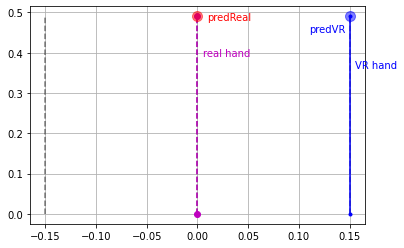

 > Running simulation:  60 seconds
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

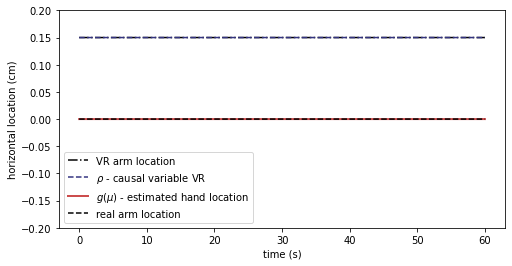

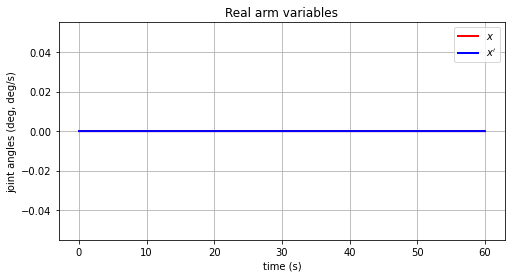

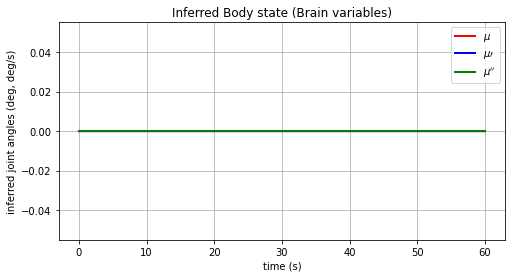

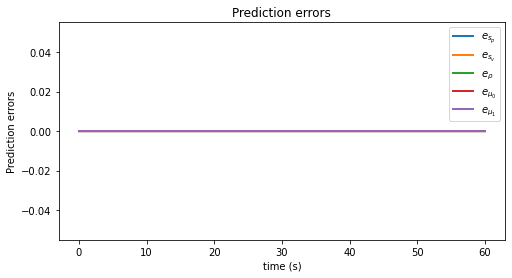

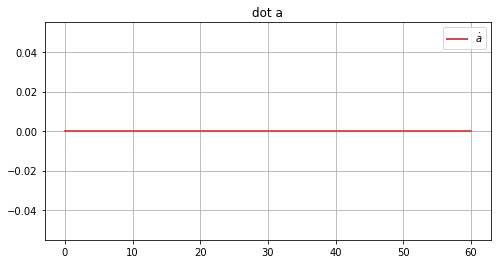

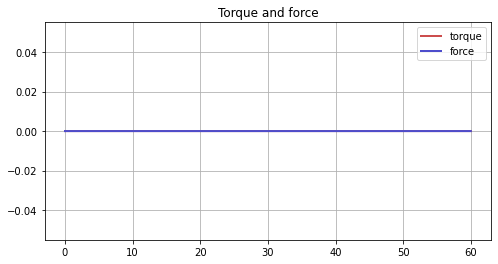

Hands location estimation at the end of the trial


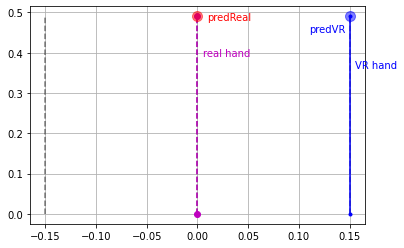

In [ ]:
location_condition = 2  # location VR arm 0 - Left, 1 - center, 2 - Right
sync_condition = 1  # synchronous
loc = ("left", "center", "right")
print(' > Building trial: loc:', loc[location_condition], ' sync:', sync_condition, 'experiment visualization below')
e = Trial(location_condition, sync_condition)

## Active inference algorithm
# Initialize variables
x0 = np.array([0, 0, 0]).reshape(3, 1)  # 1st order generalized coordinates
s_r0 = e.distance_fhand  # Initial virtual hand visual location (horizontal)
s_v0 = 0.  # Real hand visual location (horizontal)
x = x0  # latent space

## perception of the VR arm (cause)
rho0 = s_r0 
rho = rho0  

## Visual input
s_v = s_r0 # set to VR arm visual input

a0 = 0.
a = 0.

s_v_hat = model.gv(x0)  # initial predicted hand location

e.reset_data()
# Visualize initial experiment configuration
e.visualize_experiment(human, s_r0, s_v0, s_v_hat, s_r0, x0[0][0])

print(' > Running simulation: ', e.time, 'seconds')
for i in range(0, int(e.Nt) - 1):
    ## Beta causality
    model.set_beta(1.)
    ##### partial derivatives
    dgx = model.dg_dx(x)
    dgrho = model.dg_drho(rho)
    dfx = model.df_dx(x, rho)
    dfrho = model.df_drho(x, rho)
    ds_da = model.ds_da(x, rho)
    #####
    ## TODO
    ## 1.  Get an array of sensation (observations) and create a column vector of 4x1
    #x0 is the agent state 
    #    - x0[0][0] joint angle
    #    - x0[1][0] joint velocity
    #s_v is the visual input horizontal axis location
    #s_r0 is the virtual hand location horizontal axis location 
    s = np.array([0.,0.,0.,0.]).reshape(4, 1)
    

    ## 2. Compute sensory prediction error (s - g(\mu, \rho)) and store in es
    es = np.array([0.,0.,0.,0.]).reshape(4, 1)

    ## 3. Get predicted state from the model dynamics f(x,rho) and store in fx
    # fx = 
    ## 4. Compute the dynamics prediction error and store in variable ex
    # Dynamics prediction error  (D\mu - f(\mu,\rho)) where D\mu is x[1][0], x[2][0], 0.
    # Remember that everything should be a column vector
    # ex = np.array([x[1][0], x[2][0], 0.]).reshape(3, 1) - fx # I leave it to help :)
    ex = np.array([0, 0, 0]).reshape(3, 1)

    ## 4. Perception inference (FEP) (Oliver & Lanillos 2019, Friston 2010)
    # state update
    # xdot = D\mu + \partial_\mu g^T \Sigma_s^-1 error_s + \partial_\mu f^T \Sigma_x^-1 error_\mu - D\Sigma_x^-1 error_\mu
    # change the 0 by each term
    xdot =  np.array([0, 0, 0]).reshape(3, 1) # <- D\mu, I initialized to zeros but should be to \D\mu
    xdot += 0 # <- \partial_\mu g^T \Sigma_s^-1 error_s 
    xdot += 0 # <- \partial_\mu f^T \Sigma_x^-1 error_\mu
    xdot -= 0 # <- np.array([human.Sigma_x_1[1][1] * ex[1][0], human.Sigma_x_1[2][2] * ex[2][0], 0.]).reshape(3, 1)  #

    x = x + e.dt * xdot  # integration

    # 5. Active Inference (FEP) (Oliver & Lanillos 2019, Friston 2010)
    # Compute the change on the action
    # adot = - model.a_gain * \partial_a s * \Sigma^-1 error_sp (only proprioception) 
    adot = 0 # <- -model.a_gain * ds_da * \Sigma^-1 error_proprioception (postion in the horizontal axis)

    a = a + e.dt * adot  # integration

    #### Real arm
    # real change on the arm (real world model)
    x0dot = model.f_real(x0, rho, a)  # update real state
    x0 = x0 + e.dt * x0dot  # integration 

    s_v0 = model.g_real(x0)  # update real hand location
    s_v_hat = model.gv(x)  # new predicted real hand location

    # Storing values for visualization
    e.data.append(
        [x[0][0],
         x[1][0],
         rho,
         s_v_hat,
         adot,
         a,
         x0[0][0],  # 6
         x0[1][0],  # 7
         es[0][0],  # 8
         es[1][0],  # 9
         es[2][0],  # 10
         ex[0][0],  # 11
         ex[1][0],  # 12
         0,  # 13
         s[0][0],  # 14
         a * np.cos(x0[0][0]),  # a/(human.L*np.sin(np.pi/2 -x0[0][0])) , # 15 force
         x[2][0],  # 16 acceleration
         s_v0  # 17 Real hand location
         ]
    )

    print('.', end='')

# Visualize final configuration and hands location estimation
e.visualize_data()
e.visualize_experiment(human, s_r0, s_v0, s_v_hat, s_r0, x0[0][0])